
# 2/3/4 species Competitive Lotka-Volterra

Adapted from the numpyro predator-prey example
http://num.pyro.ai/en/stable/examples/ode.html


In [3]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import nn

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np

import arviz as az

numpyro.set_host_device_count(2)

###   2-species

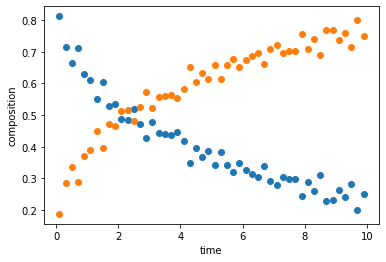

In [33]:
#Recover parameters via inference from data from mathematica simulation for 2 species:
df=pd.read_csv("data/sim.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2]]).T

plt.scatter(week, data[:, 0])
plt.scatter(week, data[:, 1])
plt.xlabel("time")
plt.ylabel("composition")
plt.show()

In [38]:
def dz_dt(z : float, t : float, theta : float):

    z1 = z[0]
    z2 = z[1]
    a11, a12, a21, a22 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    
    dz1_dt = z1 * (1 - (a11 * z1 + a12 * z2))
    dz2_dt = z2 * (1 - (a21 * z1 + a22 * z2))
    
    return jnp.stack([dz1_dt, dz2_dt])


Sloc = 0.25 # scale the location prior
Svar = 0.5 # scale the variance prior

def model(N : int, y = None):
    
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    ts = jnp.arange(float(N))
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low = 0.0,
            loc = jnp.repeat(Sloc, 4),
            scale = jnp.repeat(Svar, 4),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol = 1e-5, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs=y)

    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples=500,
    num_warmup=500,
    num_chains=1,
    progress_bar=True,
)

mcmc.run(PRNGKey(1), N = data.shape[0], y = np.round(100 * data))
mcmc.print_summary()

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.09it/s, 31 steps of size 9.51e-02. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.35      0.19      0.33      0.05      0.62     99.19      1.00
  theta[1]      0.56      0.19      0.54      0.21      0.82     89.56      1.04
  theta[2]      0.32      0.17      0.30      0.04      0.55    100.82      1.00
  theta[3]      0.55      0.17      0.54      0.27      0.82     92.47      1.04
 z_init[0]      3.30      0.87      3.20      1.91      4.59    116.65      1.00
 z_init[1]      1.74      0.79      1.59      0.68      2.99     88.93      1.00

Number of divergences: 3


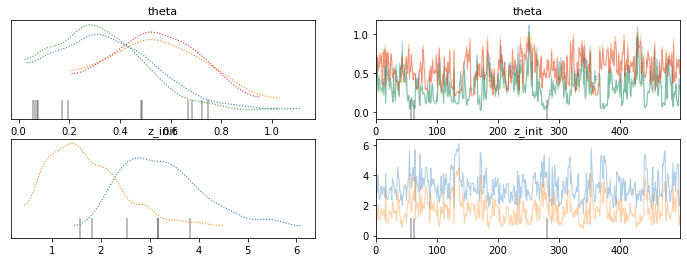

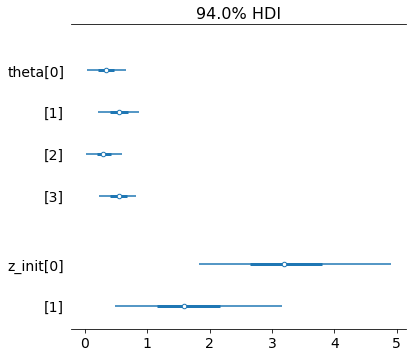

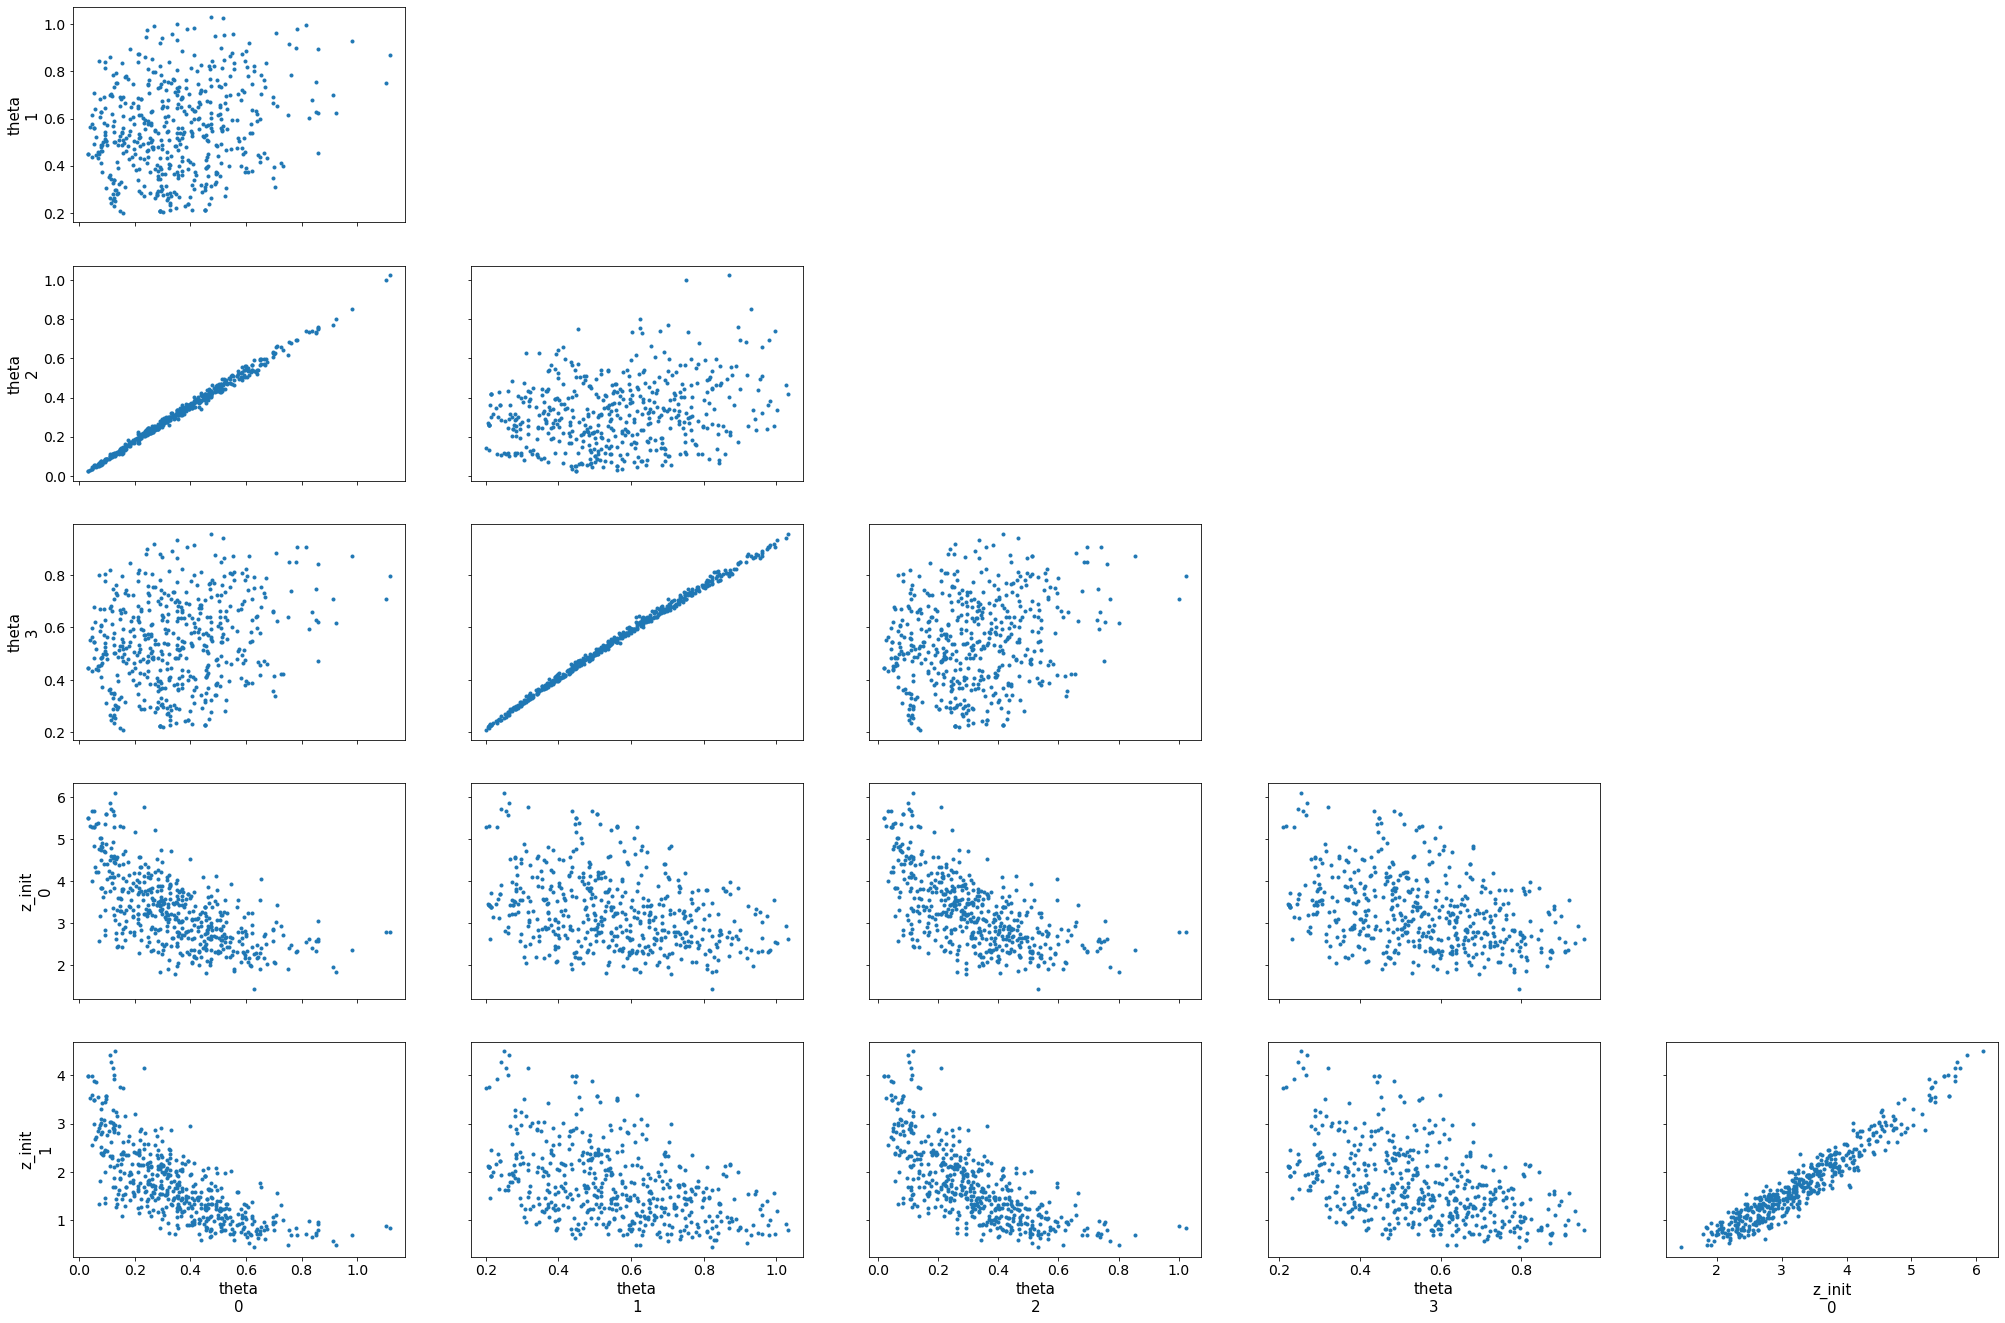

In [39]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()


az.plot_forest(az.from_numpyro(mcmc), combined = True)
# plt.vlines(0, 0, 100)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

In [42]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

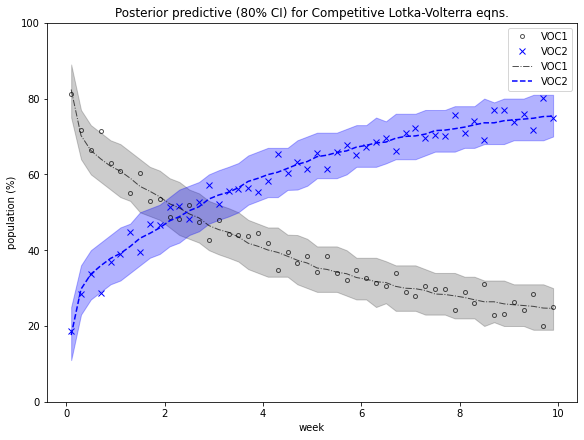

In [43]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, 100 * data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, 100 * data[:, 1], "bx", label="VOC2")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week,  mu[:, 1], "b--", label="VOC2")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()

### 3-species

In [29]:
df = pd.read_csv("data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

trans_data =  np.round(100 *data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
trans_data[:5]

array([[75.,  7., 18.],
       [67., 13., 20.],
       [59.,  8., 33.],
       [50., 12., 38.],
       [44., 12., 44.]])

In [30]:
Sloc = 0.01 # scale the location prior
Svar = 0.01 # scale the variance prior

def dz_dt(z : float, t : float, theta : float):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    
    a1, a11, a12, a13, a21, a2, a22, a23, a3, a31, a32, a33 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
    )
    
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3))
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N : int, y = None):
    
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """

    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low = 0.0,
            loc = jnp.repeat(Sloc, 12),
            scale = jnp.repeat(Svar, 12),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs = y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_samples=500,
    num_warmup=500,
    num_chains=2,
    progress_bar=True,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00      0.00      0.01    168.25      1.01
  theta[1]      0.01      0.01      0.01      0.00      0.02    191.49      1.01
  theta[2]      0.01      0.01      0.01      0.00      0.02    337.06      1.00
  theta[3]      0.01      0.01      0.01      0.00      0.02    594.81      1.00
  theta[4]      0.01      0.00      0.00      0.00      0.01    403.11      1.00
  theta[5]      0.03      0.01      0.03      0.02      0.04    226.20      1.00
  theta[6]      0.02      0.01      0.02      0.01      0.03    204.84      1.03
  theta[7]      0.01      0.00      0.00      0.00      0.01    231.66      1.02
  theta[8]      0.04      0.01      0.04      0.03      0.05    370.47      1.00
  theta[9]      0.00      0.00      0.00      0.00      0.01    316.24      1.00
 theta[10]      0.02      0.01      0.02      0.01      0.03    114.94      1.01
 theta[11]      0.02      0

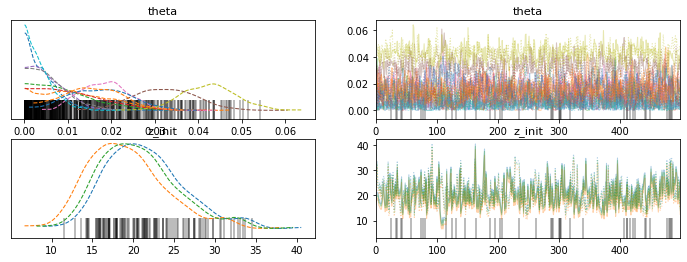

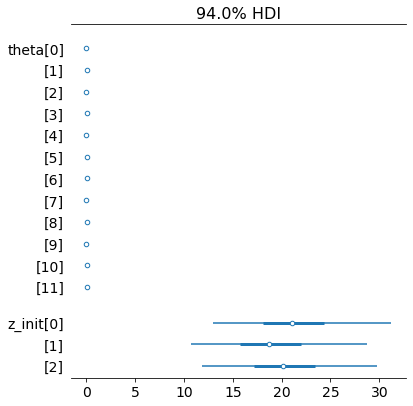

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


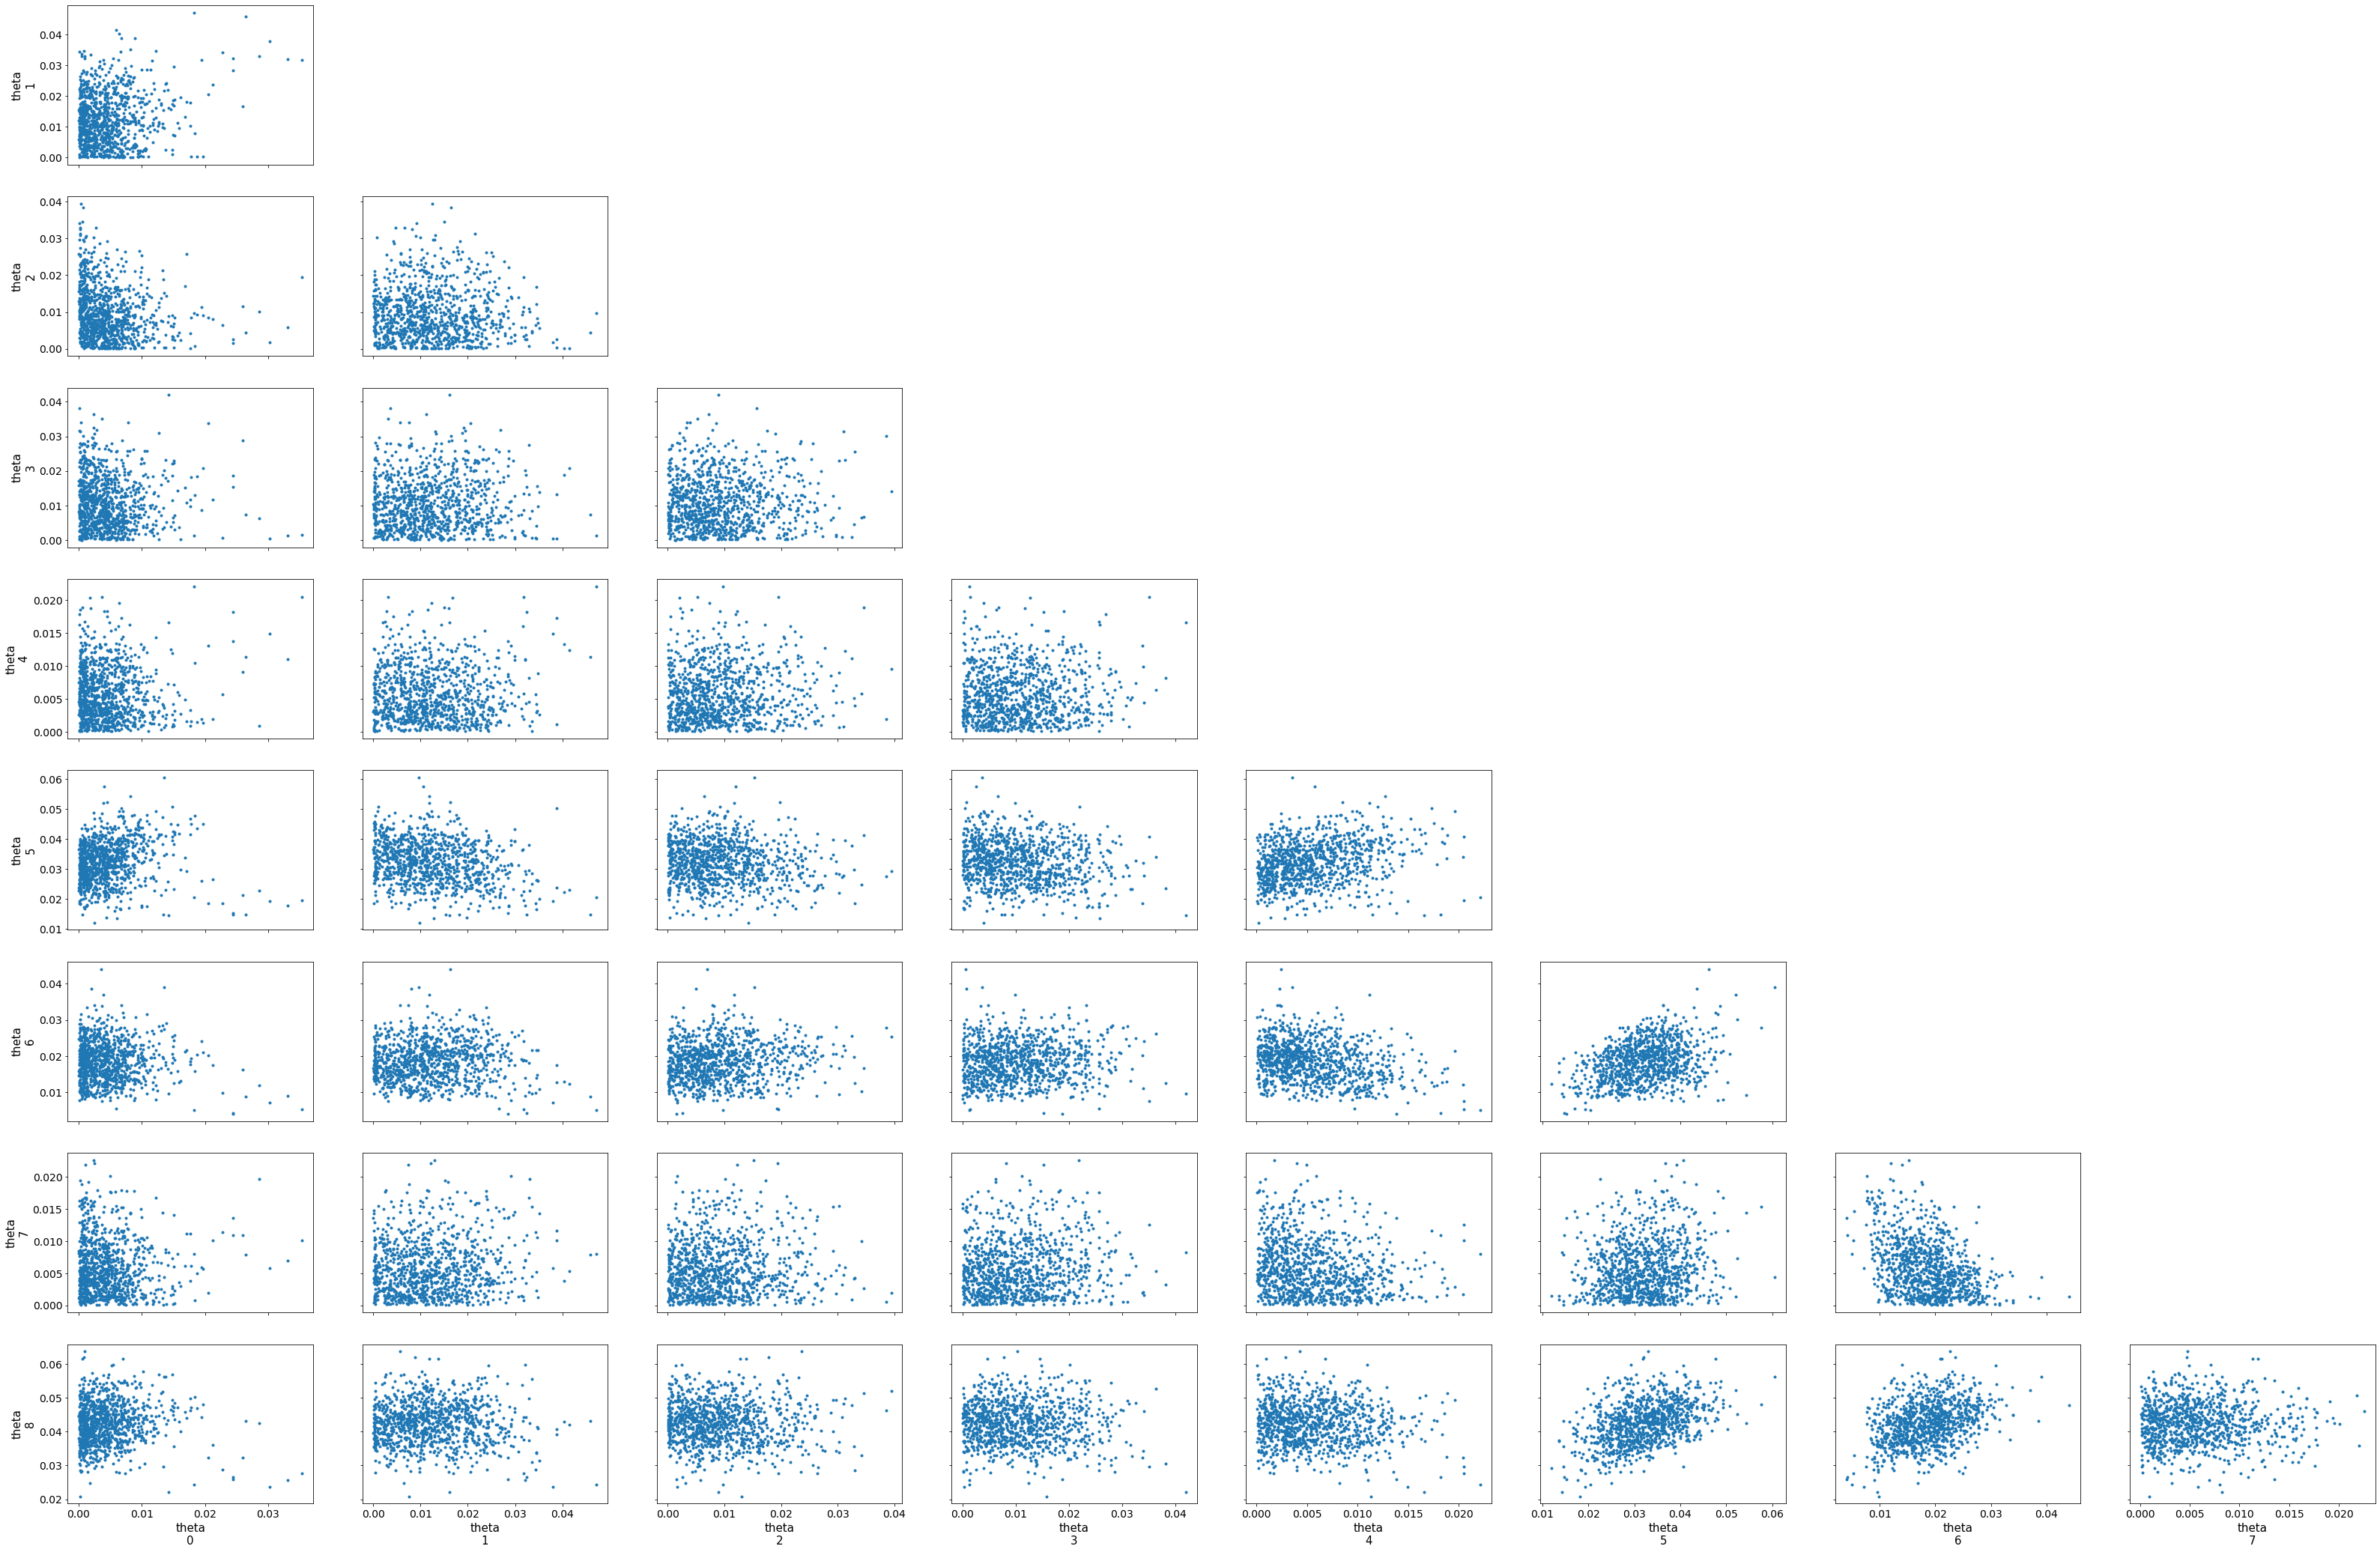

In [31]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()

az.plot_forest(az.from_numpyro(mcmc), combined = True)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

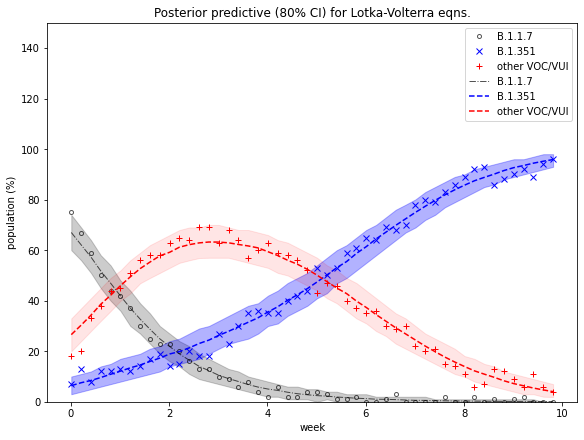

In [32]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()

## 4-species

In [4]:
#Recover parameters via inference from data from mathematica simulation for 3 species:
df=pd.read_csv("data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

# rounding fails if you have three so just need to do some sort of data massaging
trans_data =  np.round(100 * data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
col12 = trans_data[...,0:2]
col4 = np.random.randint(0, 4, trans_data.shape[0])
col3 = trans_data[...,2] - col4
trans_data = np.append(col12, np.append([col3], [col4],0).T, 1)

trans_data[:5]

array([[75.,  7., 16.,  2.],
       [67., 13., 18.,  2.],
       [59.,  8., 31.,  2.],
       [50., 12., 36.,  2.],
       [44., 12., 41.,  3.]])

In [5]:
Sloc = 0.01 # scale the location prior
Svar = 0.01 # scale the variance prior
def dz_dt(z : float, t : float , theta : float):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    z4 = z[3]
    
    a1, a11, a12, a13, a14, a21, a2, a22, a23, a24, a3, a31, a32, a33, a34, a4, a41, a42, a43, a44,  = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
        theta[..., 12],
        theta[..., 13],
        theta[..., 14],
        theta[..., 15],
        theta[..., 16],
        theta[..., 17],
        theta[..., 18],
        theta[..., 19],
    )
    
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3 + a14 * z4))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3 + a24 * z4))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3 + a34 * z4))
    dz4_dt = a4 * z4 * (1 - (a41 * z1 + a42 * z2 + a43 * z3 + a44 * z4))
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt, dz4_dt])


def model(N : int, y = None):

    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([4]))
    ts = jnp.arange(float(N))
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc= Sloc * jnp.repeat(1, 20),
            scale= Svar * jnp.repeat(1, 20),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs=y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples = 500,
    num_warmup = 500,
    num_chains = 2,
    progress_bar = False,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00      0.00      0.01     45.44      1.04
  theta[1]      0.01      0.01      0.01      0.00      0.03    140.25      1.01
  theta[2]      0.01      0.01      0.01      0.00      0.02    847.35      1.00
  theta[3]      0.01      0.01      0.01      0.00      0.02    671.62      1.00
  theta[4]      0.01      0.01      0.01      0.00      0.02    885.91      1.00
  theta[5]      0.01      0.00      0.00      0.00      0.01    552.80      1.00
  theta[6]      0.03      0.01      0.03      0.03      0.05     86.59      1.02
  theta[7]      0.01      0.01      0.01      0.00      0.02    178.81      1.01
  theta[8]      0.01      0.00      0.01      0.00      0.01    557.70      1.00
  theta[9]      0.01      0.01      0.01      0.00      0.02    174.31      1.02
 theta[10]      0.05      0.01      0.05      0.03      0.05    703.40      1.00
 theta[11]      0.00      0

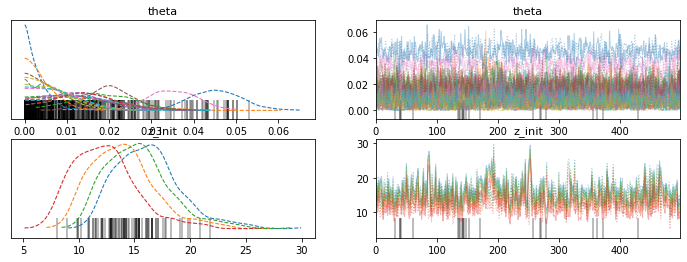

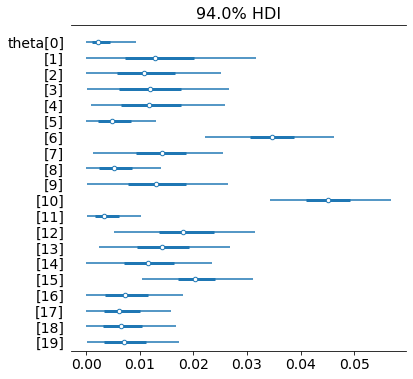

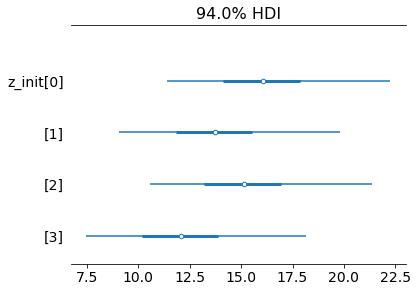

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


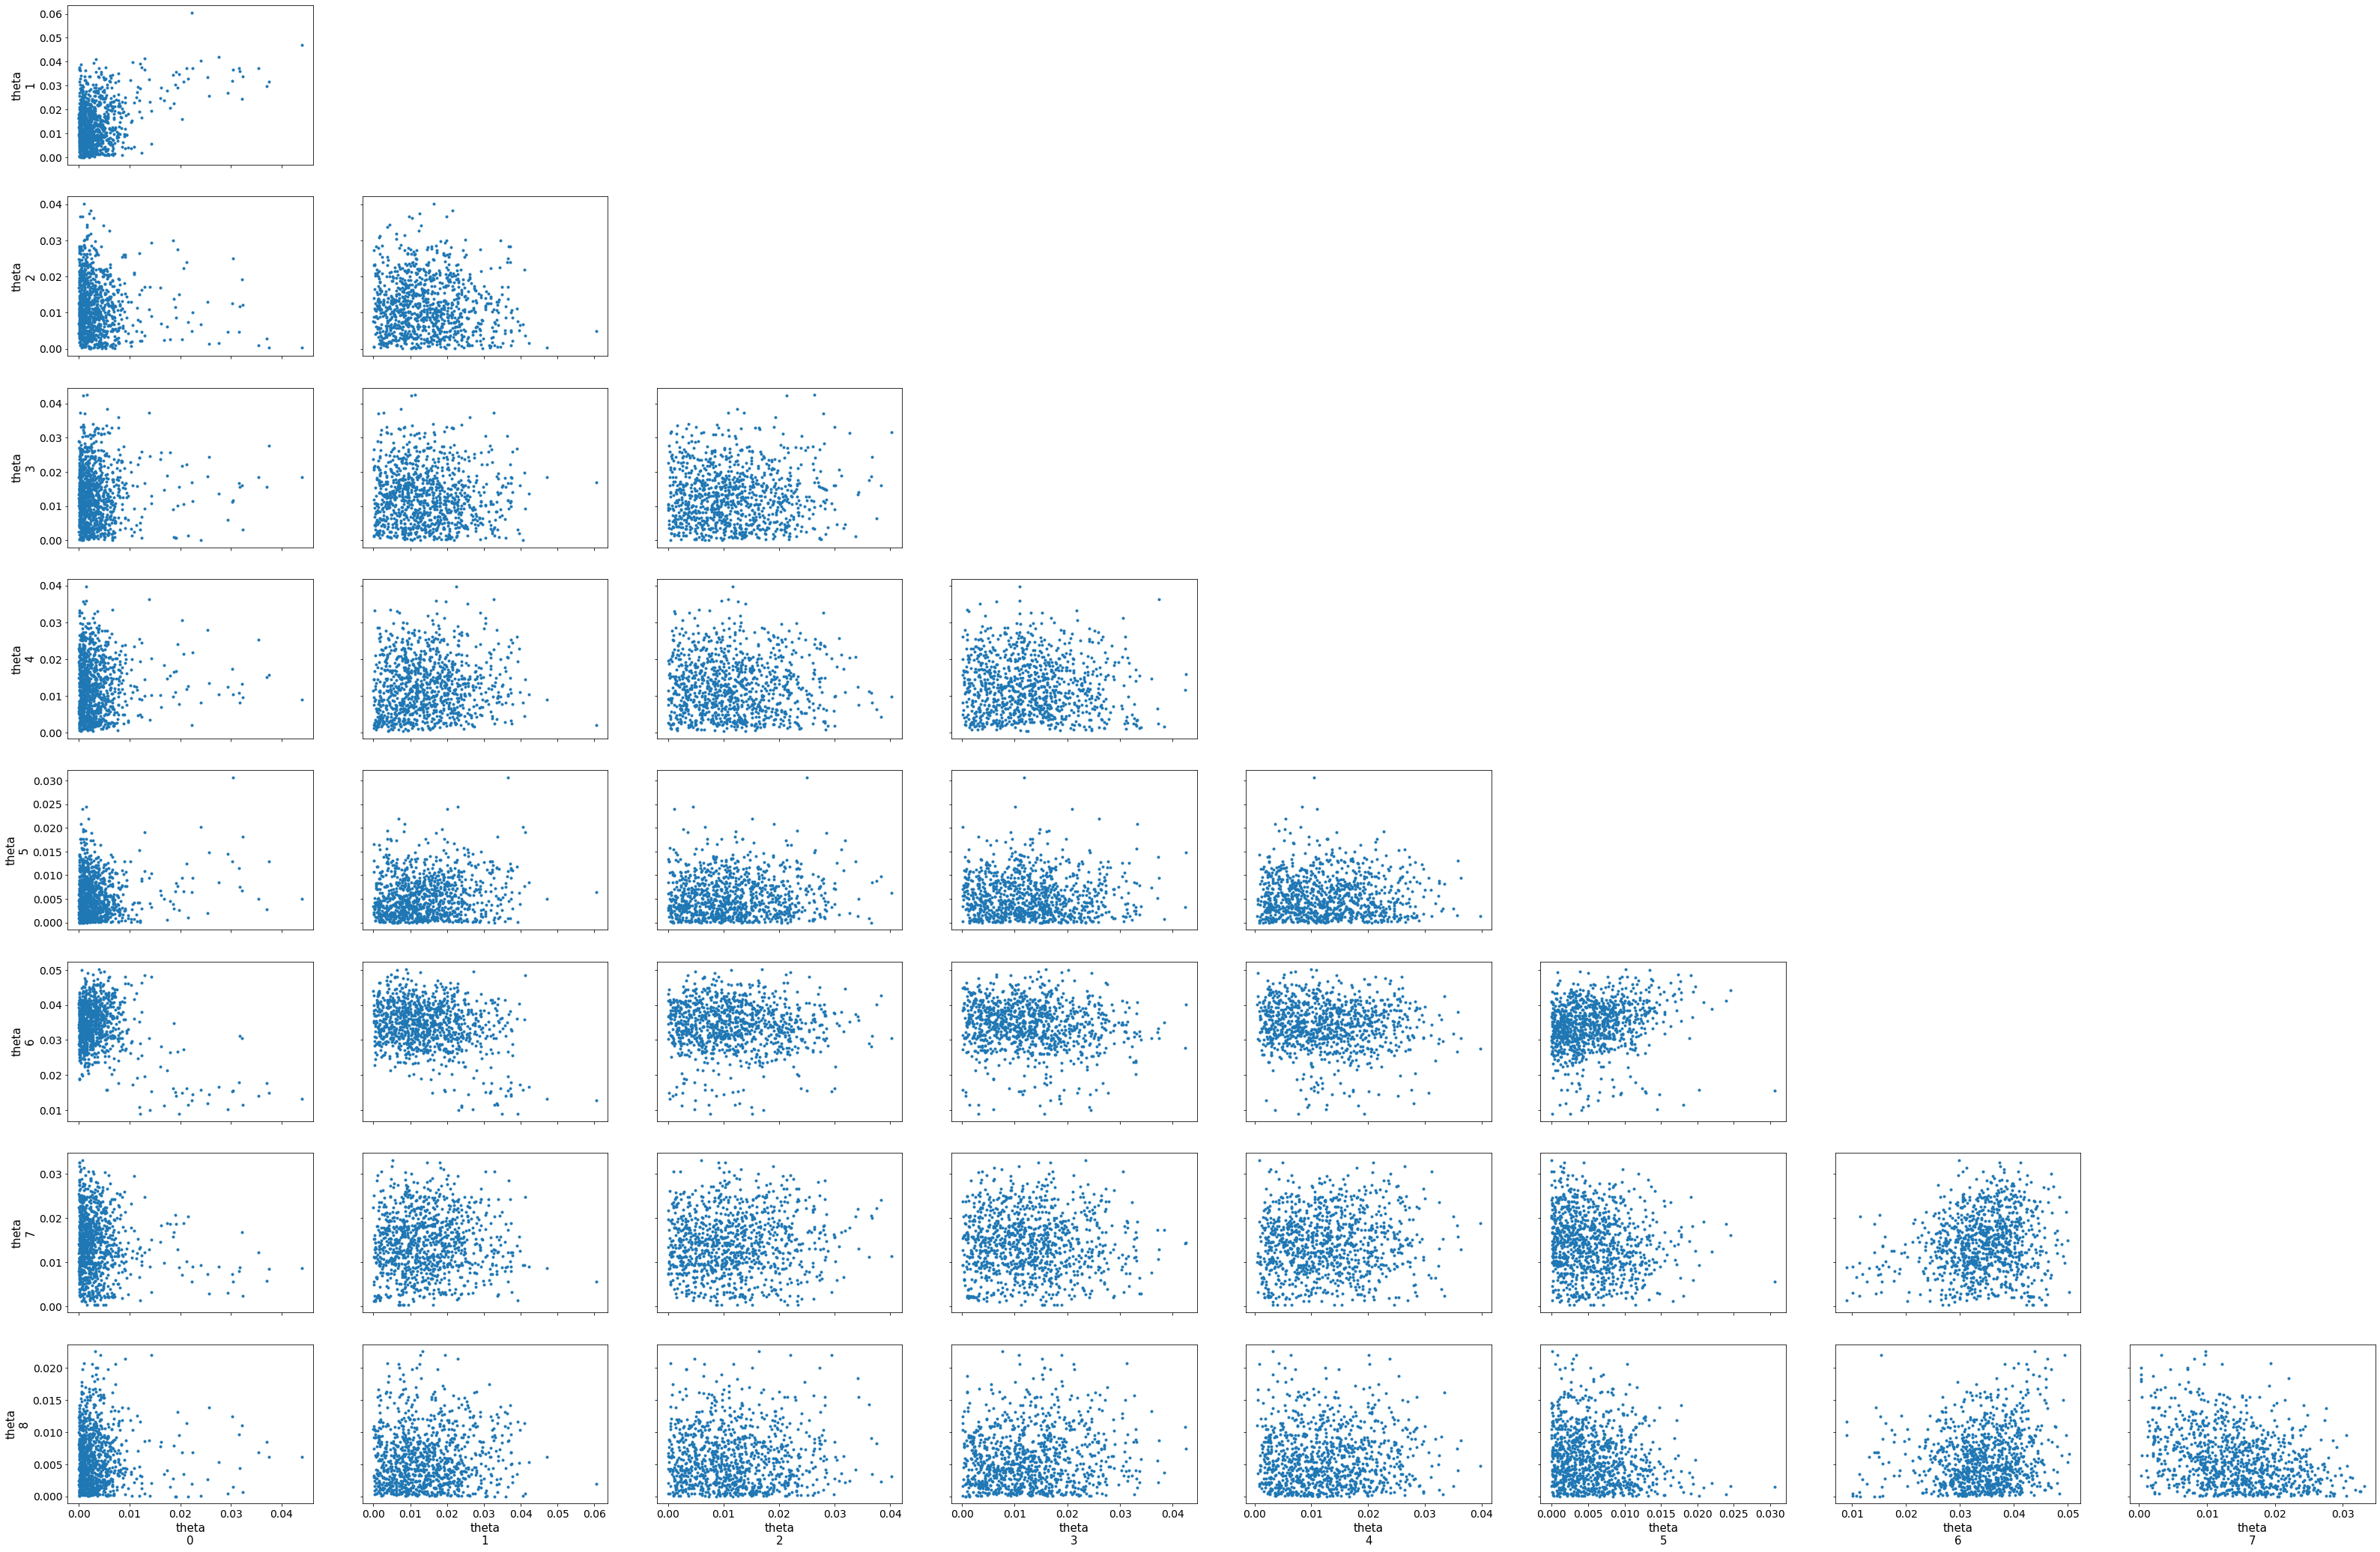

In [21]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['theta'], combined = True)
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['z_init'], combined = True)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

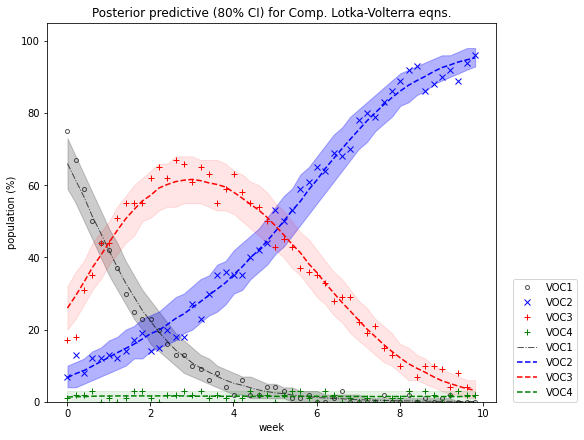

In [12]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
plt.plot(week, mu[:, 3], "g--", label="VOC4")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()

### Assume sum to 1 to drop 5 parameters

In [5]:
Sloc = 0.01 # scale the location prior
Svar = 0.01 # scale the variance prior
def dz_dt(z : float, t : float , theta : float):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    z4 = z[3]
    
    a1, a11, a12, a13, a14, a21, a2, a22, a23, a24, a3, a31, a32, a33, a34,  = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
        theta[..., 12],
        theta[..., 13],
        theta[..., 14],
    )
    
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3 + a14 * z4))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3 + a24 * z4))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3 + a34 * z4))
    dz4_dt = - dz1_dt - dz2_dt - dz3_dt
    
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt, dz4_dt])


def model(N : int, y = None):

    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([4]))
    ts = jnp.arange(float(N))
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc= Sloc * jnp.repeat(1, 15),
            scale= Svar * jnp.repeat(1, 15),
        ),
    )
    
    z = odeint(dz_dt, z_init, ts, theta, rtol = 1e-7, atol = 1e-6, mxstep = 1000)
    numpyro.sample("y", dist.Multinomial(logits = z, total_count = 100), obs = y)
    
    
mcmc = MCMC(
    NUTS(model, dense_mass = True),
    num_samples = 500,
    num_warmup = 500,
    num_chains = 2,
    progress_bar = True,
)

mcmc.run(PRNGKey(1), N = trans_data.shape[0], y = trans_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.02      0.01      0.02      0.01      0.04    457.93      1.00
  theta[1]      0.03      0.01      0.03      0.02      0.04    731.83      1.00
  theta[2]      0.01      0.01      0.01      0.00      0.02    473.39      1.00
  theta[3]      0.02      0.01      0.02      0.00      0.03    524.88      1.00
  theta[4]      0.02      0.01      0.01      0.00      0.03    273.51      1.01
  theta[5]      0.01      0.01      0.01      0.00      0.02    472.35      1.00
  theta[6]      0.02      0.01      0.01      0.01      0.02    477.18      1.00
  theta[7]      0.01      0.01      0.01      0.00      0.02    367.37      1.01
  theta[8]      0.01      0.01      0.01      0.00      0.02    378.83      1.01
  theta[9]      0.01      0.01      0.01      0.00      0.02    342.28      1.01
 theta[10]      0.04      0.01      0.04      0.03      0.05    736.93      1.00
 theta[11]      0.00      0

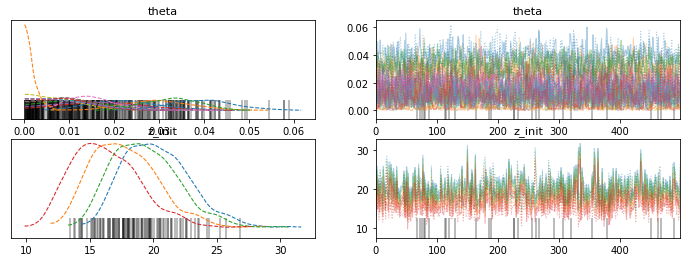

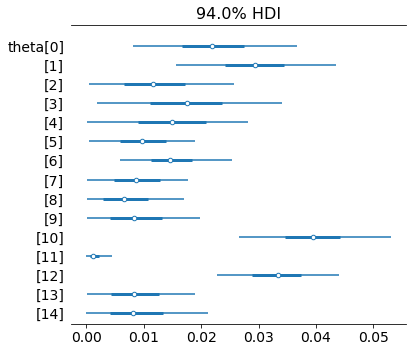

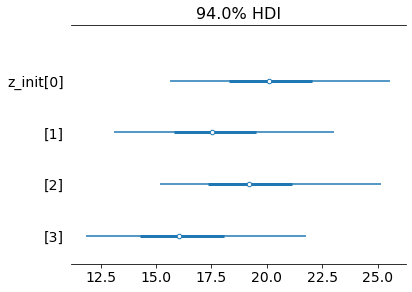

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


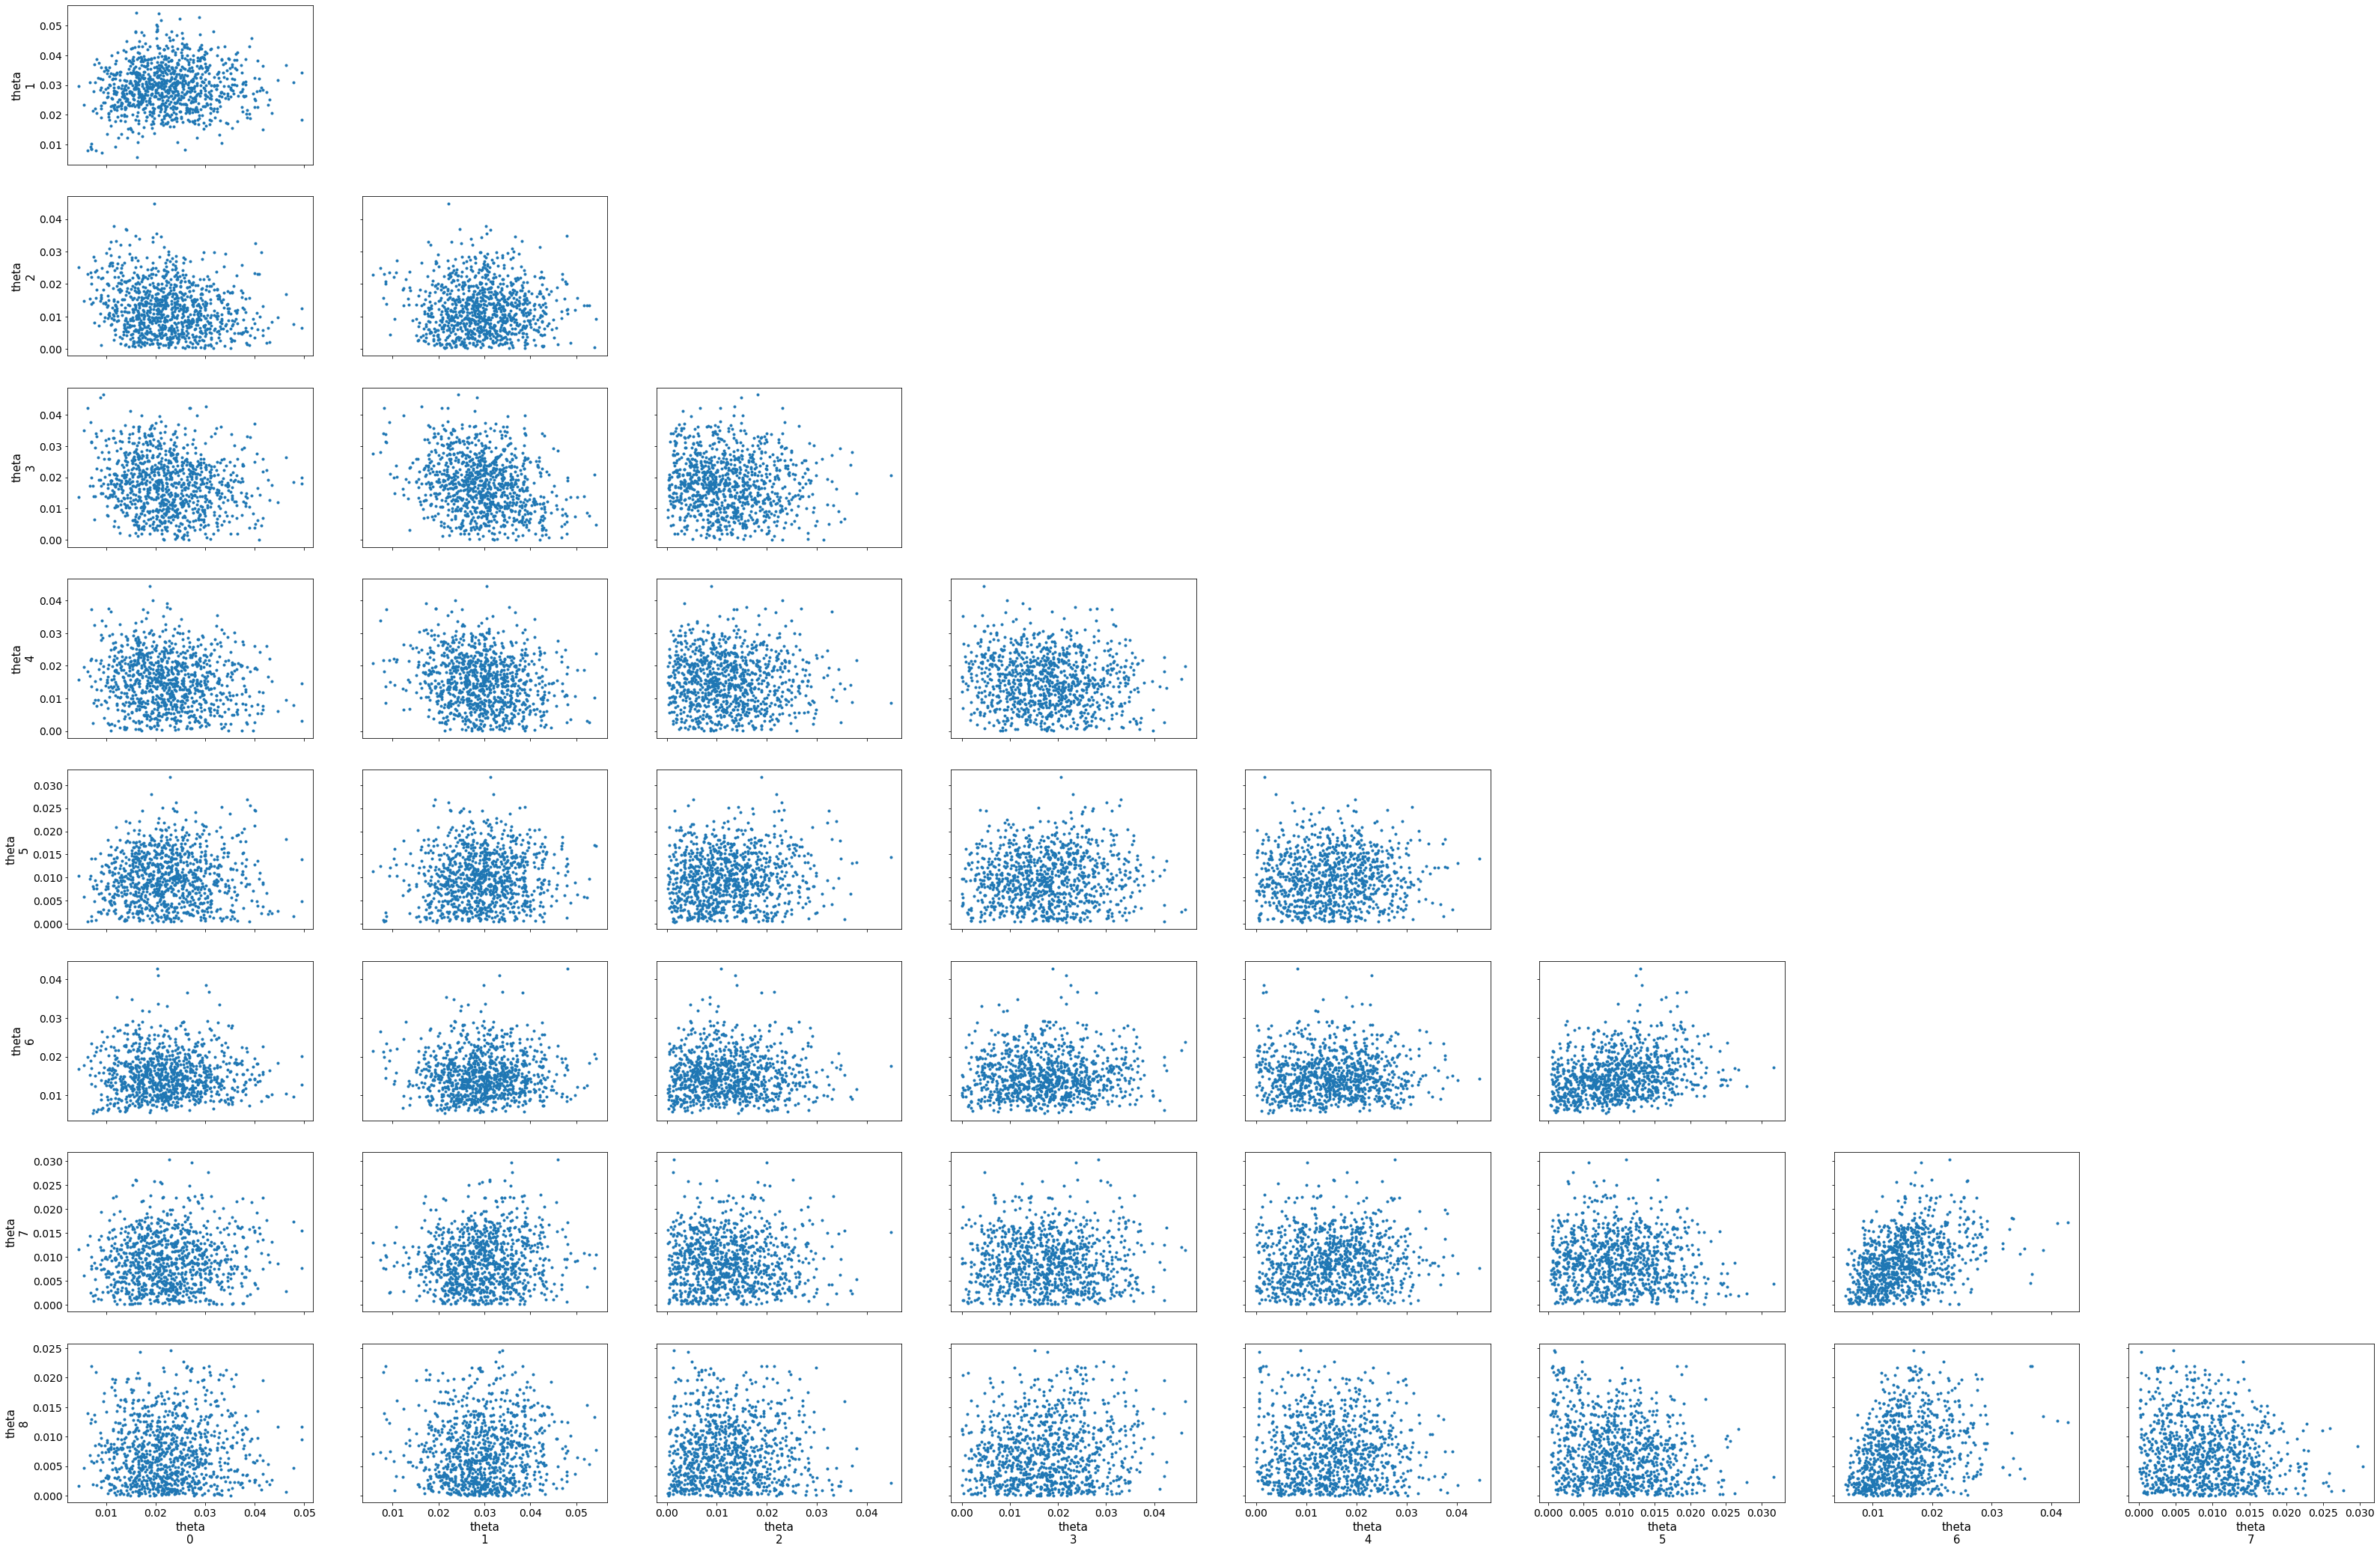

In [6]:
az.plot_trace(az.from_numpyro(mcmc), compact = True, combined = True);
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['theta'], combined = True)
plt.show()

az.plot_forest(az.from_numpyro(mcmc), var_names = ['z_init'], combined = True)
plt.show()

az.plot_pair(az.from_numpyro(mcmc))
plt.show()

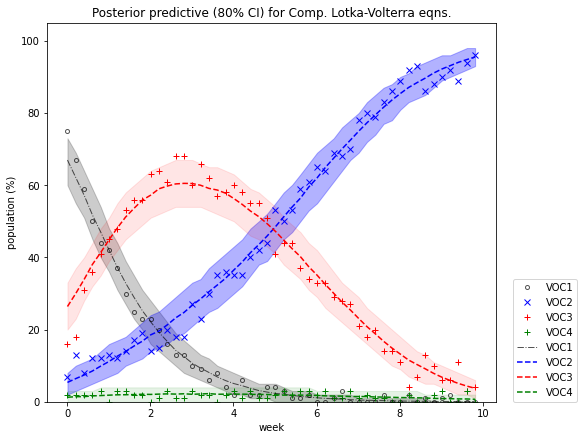

In [7]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="VOC1", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="VOC2")
plt.plot(week, trans_data[:, 2], "r+", label="VOC3")
plt.plot(week, trans_data[:, 3], "g+", label="VOC4")
plt.plot(week, mu[:, 0], "k-.", label="VOC1", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="VOC2")
plt.plot(week, mu[:, 2], "r--", label="VOC3")
plt.plot(week, mu[:, 3], "g--", label="VOC4")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 105), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Comp. Lotka-Volterra eqns.")
plt.legend(loc=(1.04,0))
plt.show()